# Bulk RNA-seq generate 'interrupted' cells to interpolate scRNA-seq

The limited number of cells available for single-cell sequencing has led to 'interruptions' in the study of cell development and differentiation trajectories. In contrast, bulk RNA-seq sequencing of whole tissues contains, in principle, 'interrupted' cells. To our knowledge, there is no algorithm for extracting 'interrupted' cells from bulk RNA-seq. There is a lack of tools that effectively bridge the gap between bulk-seq and single-seq analyses.

We developed BulkTrajBlend in OmicVerse, which is specifically designed to address cell continuity in single-cell sequencing.BulkTrajBlend first deconvolves single-cell data from Bulk RNA-seq and then uses a GNN-based overlapping community discovery algorithm to identify contiguous cells in the generated single-cell data.

Colab_Reproducibility：https://colab.research.google.com/drive/1HulVXQIlUEcpGRDZo4MxcHYOjnVhuCC-?usp=sharing


In [1]:
import omicverse as ov
from omicverse.utils import mde
import scanpy as sc
import scvelo as scv
ov.utils.ov_plot_set()


2023-05-27 17:29:28.741101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 17:29:29.211951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-27 17:29:29.212047: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-27 17:29:29.212054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

/mnt/data/env/pyomic/lib/python3.8/site-packages/phate/__init__.py
/mnt/data/env/pyomic/lib/python3.8/site-packages/phate/__init__.py


## loading data

For illustration, we apply differential kinetic analysis to dentate gyrus neurogenesis, which comprises multiple heterogeneous subpopulations.

We utilized single-cell RNA-seq data (GEO accession: GSE95753) obtained from the dentate gyrus of the hippocampus in rats, along with bulk RNA-seq data (GEO accession: GSE74985). 

In [2]:
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [3]:
import numpy as np
bulk=ov.utils.read('GSE74985_mergedCount.txt.gz',index_col=0)
bulk=ov.bulk.Matrix_ID_mapping(bulk,'pair_GRCm39.tsv')
bulk.head()

,dg_d_1,dg_d_2,dg_d_3,dg_v_1,dg_v_2,dg_v_3,ca4_1,ca4_2,ca4_3,ca3_d_1,...,ca3_v_3,ca2_1,ca2_2,ca2_3,ca1_d_1,ca1_d_2,ca1_d_3,ca1_v_1,ca1_v_2,ca1_v_3
Fnip2,784,301,339,659,924,988,494,269,394,309,...,709,467,391,558,343,634,395,112,200,240
Gm22713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zfp595,0,72,10,20,104,101,66,30,131,80,...,144,73,64,81,92,60,45,6,1,10
Treh,0,0,0,6,0,0,1,2,0,0,...,0,1,2,0,0,0,0,1,0,0
Cat,1299,539,492,489,502,779,1370,882,1231,1595,...,1594,805,694,917,1506,1325,1053,299,257,372


## Configure the BulkTrajBlend model

Here, we import the bulk RNA-seq and scRNA-seq data we have just prepared as input into the BulkTrajBlend model. We use the lazy function for preprocessing and we note that `dg_d` represents the neuronal data of the dentate gyrus, which we merge as it is three replicates.

Note that the bulk RNA-seq and scRNA-seq we use here are raw data, not normalised and logarithmic, and are not suitable for use with the lazy function if your data has already been processed. It is important to note that single cell data cannot be scale

In [4]:
bulktb=ov.bulk2single.BulkTrajBlend(bulk_seq=bulk,single_seq=adata,
                                    celltype_key='clusters',)
bulktb.bulk_preprocess_lazy(group=['dg_d_1','dg_d_2','dg_d_3'])
bulktb.single_preprocess_lazy()

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data


## Training the beta-VAE model

We first generated single cell data from the bulk RNA-seq data using beta-VAE and filtered out noisy cells using the size of the leiden as a constraint.

`cell_target_num` represents the expected number of cells in each category and we do not use a least squares approach to fit the cell proportions here.

In [5]:
bulktb.vae_configure(cell_target_num=100)
'''
bulktb.vae_train(batch_size=256,
    learning_rate=1e-4,
    hidden_size=256,
    epoch_num=3500,
    vae_save_dir='data/dg_d/newdata/save_model',
    vae_save_name='dgd1_vae',
    generate_save_dir='data/dg_d/newdata/output',
    generate_save_name='dgd')
'''
bulktb.vae_load('data/dg_d/newdata/save_model/dgd_vae.pth')

...loading data
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
loading model from data/dg_d/newdata/save_model/dgd_vae.pth
loading model from data/dg_d/newdata/save_model/dgd_vae.pth


In [6]:
generate_adata=bulktb.vae_generate(leiden_size=25)

...generating


generating: 100%|██████████████████| 1400/1400 [00:00<00:00, 3263.67it/s]

generated done!
extracting highly variable genes


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    on highly variable genes
    with n_comps=100
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 32 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
The filter leiden is  ['18', '17', '16', '15', '14', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


<AxesSubplot: title={'center': 'The number of cells per cell type in bulk-seq data'}, xlabel='Cell type', ylabel='Cell number'>

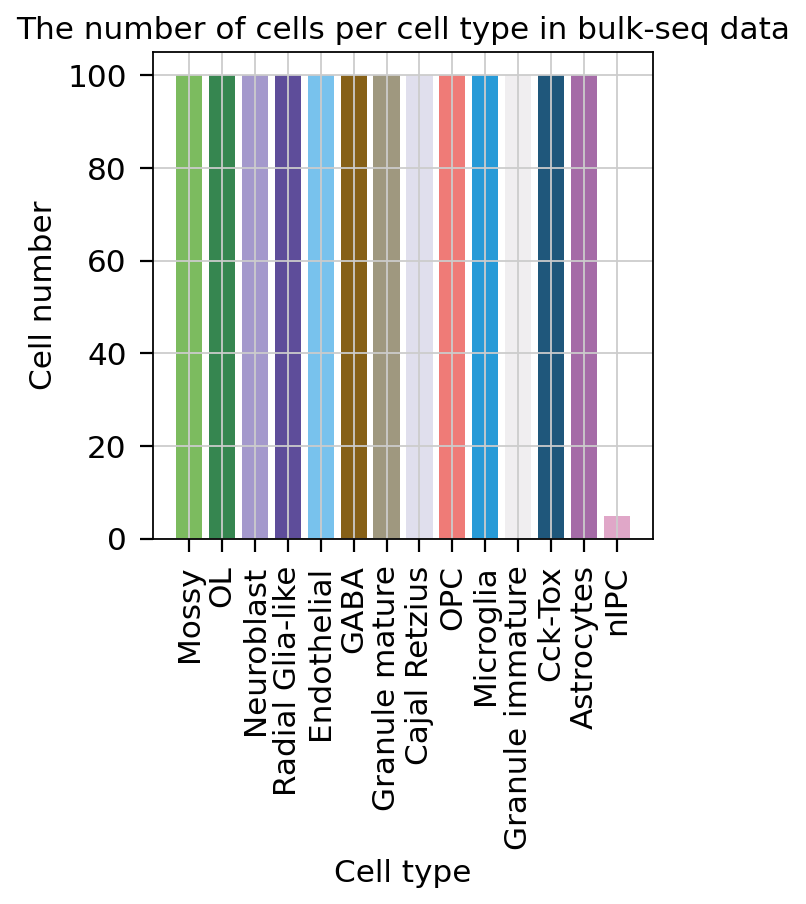

In [7]:
ov.bulk2single.bulk2single_plot_cellprop(generate_adata,celltype_key='clusters',
                                        )

## Visualize the generate scRNA-seq

To visualize the generate scRNA-seq’s learned embeddings, we use the pymde package wrapperin omicverse. This is an alternative to UMAP that is GPU-accelerated.

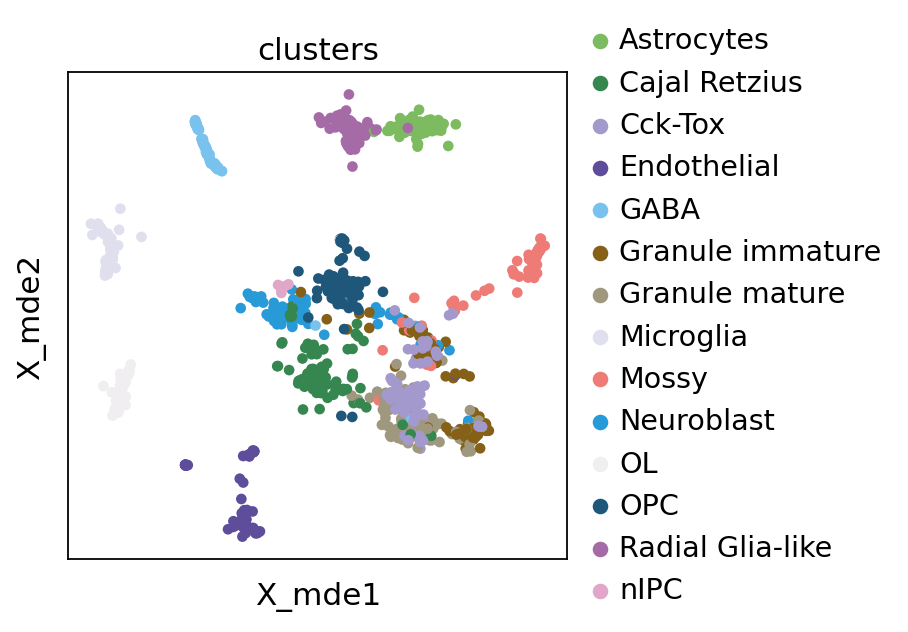

In [8]:
import scanpy as sc
from omicverse.utils import mde
generate_adata.obsm["X_mde"] = mde(generate_adata.obsm["X_pca"])
sc.pl.embedding(generate_adata,basis='X_mde',color=['clusters'],wspace=0.4,
          palette=ov.utils.pyomic_palette())

## Training the GNN model

Next, we used GNN to look for overlapping communities (community = cell type) in the generated single-cell data.

- gpu: The GPU ID for training the GNN model. Default is 0.
- hidden_size: The hidden size for the GNN model. Default is 128.
- weight_decay: The weight decay for the GNN model. Default is 1e-2.
- dropout: The dropout for the GNN model. Default is 0.5.
- batch_norm: Whether to use batch normalization for the GNN model. Default is True.
- lr: The learning rate for the GNN model. Default is 1e-3.
- max_epochs: The maximum epoch number for training the GNN model. Default is 500.
- display_step: The display step for training the GNN model. Default is 25.
- balance_loss: Whether to use the balance loss for training the GNN model. Default is True.
- stochastic_loss: Whether to use the stochastic loss for training the GNN model. Default is True.
- batch_size: The batch size for training the GNN model. Default is 2000.
- num_workers: The number of workers for training the GNN model. Default is 5.

In [11]:
bulktb.gnn_configure(max_epochs=2000)

torch have been install version: 1.13.0+cu117


There are many parameters that can be controlled during training, here we set them all to the default

- thresh: the threshold for filtered the overlap community
- gnn_save_dir: the save dir for gnn model
- gnn_save_name: the gnn model name to save


In [12]:
bulktb.gnn_train()

Epoch  675, loss.full = 0.1612, nmi = 0.68:   0%| | 0/2000 [00:16<?, ?it/


Breaking due to early stopping at epoch 675
Final nmi = 0.675
......add nocd result to adata.obs
...save trained gnn in save_model/gnn.pth.


Since the previously generated single cell data has a random nature in the construction of the neighbourhood map, the model must be loaded on the fixed generated single cell data. Otherwise an error will be reported

In [ ]:
#bulktb.gnn_load('save_model/gnn.pth')

We can use GNN to get an overlapping community for each cell.

In [13]:
res_pd=bulktb.gnn_generate()
res_pd.head()

,nocd_Mossy,nocd_Granule immature,nocd_Microglia,nocd_Radial Glia-like,nocd_GABA,nocd_Granule mature,nocd_OL,nocd_Endothelial,nocd_Cck-Tox,nocd_Neuroblast,nocd_Cck-Tox_3,nocd_Cajal Retzius,nocd_Astrocytes,nocd_OPC
C_1,1,1,0,0,0,0,0,0,1,0,0,0,0,0
C_2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
C_3,0,0,0,0,0,0,0,0,0,1,0,1,0,0
C_4,0,0,0,0,0,1,0,0,0,0,0,0,0,0
C_5,0,0,0,1,0,0,0,0,0,0,0,0,0,0


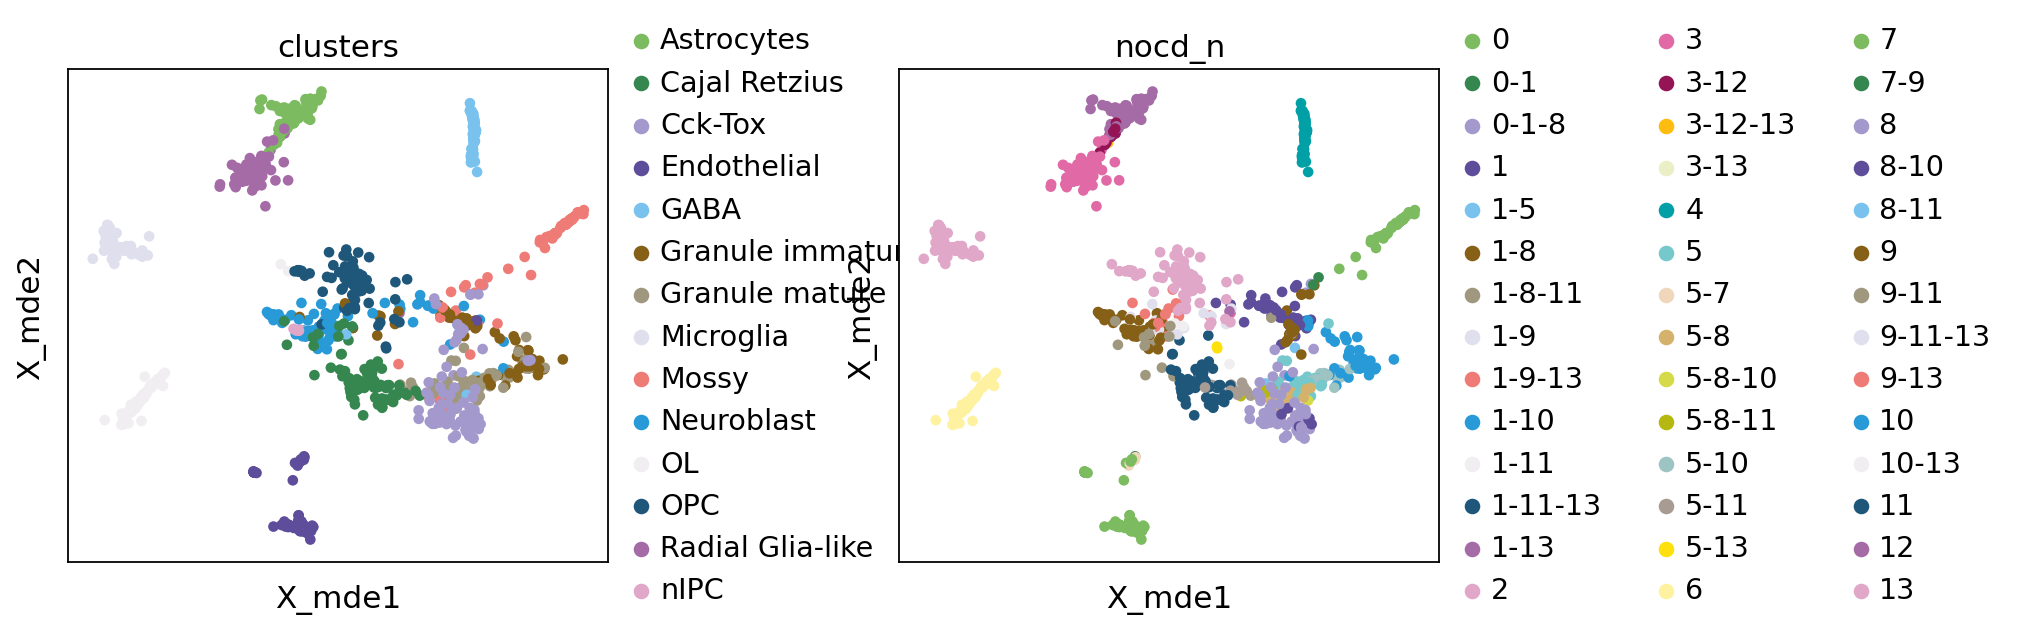

In [14]:
bulktb.nocd_obj.adata.obsm["X_mde"] = mde(bulktb.nocd_obj.adata.obsm["X_pca"])
sc.pl.embedding(bulktb.nocd_obj.adata,basis='X_mde',color=['clusters','nocd_n'],wspace=0.4,
          palette=ov.utils.pyomic_palette())

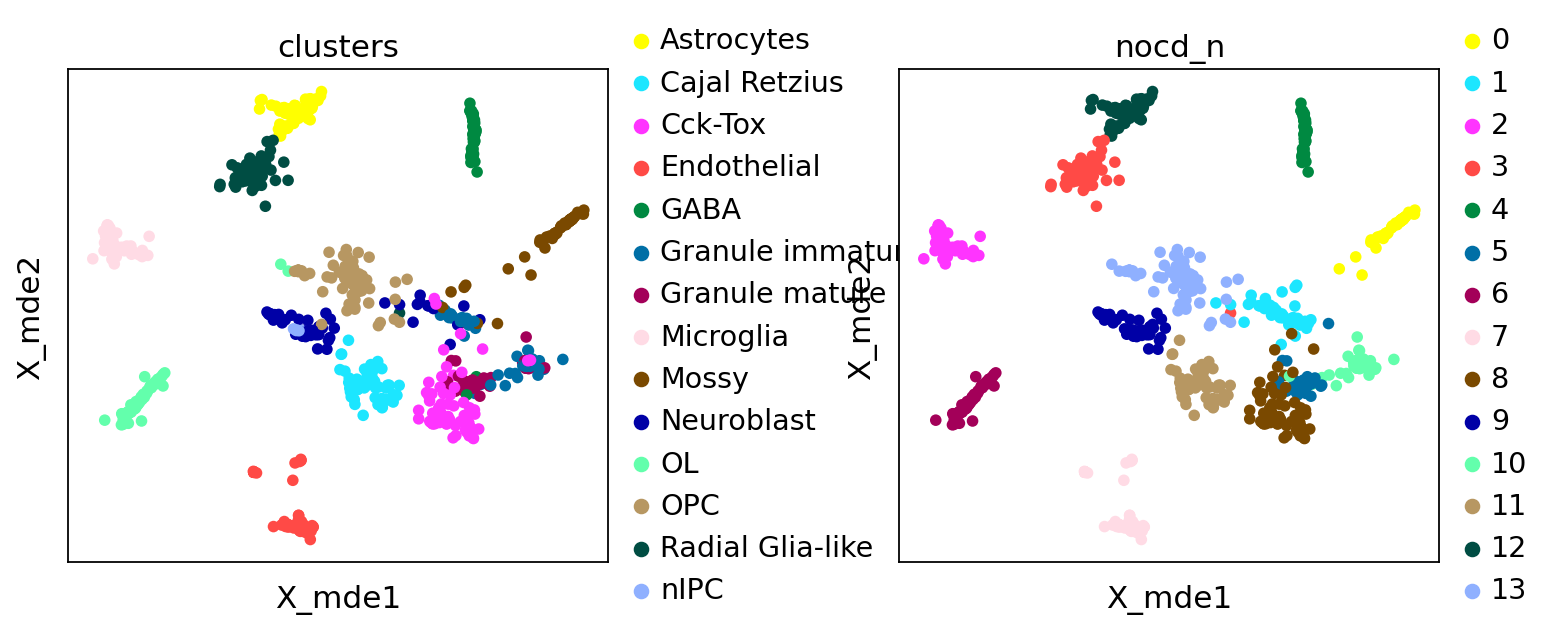

In [15]:
sc.pl.embedding(bulktb.nocd_obj.adata[~bulktb.nocd_obj.adata.obs['nocd_n'].str.contains('-')],
                basis='X_mde',
           color=['clusters','nocd_n'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

## Interpolation of the "interruption" cell

A simple function is provided to interpolate the "interruption" cells in the original data, making the single cell data continuous.

In [16]:
print('raw cells: ',bulktb.single_seq.shape[0])
#adata1=bulktb.interpolation('Neuroblast')
adata1=bulktb.interpolation('OPC')
print('interpolation cells: ',adata1.shape[0])

raw cells:  2930
interpolation cells:  3061


## Visualisation of single cell data before and after interpolation


In [17]:
adata1.raw = adata1
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata1 = adata1[:, adata1.var.highly_variable]
sc.pp.scale(adata1, max_value=10)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [18]:
sc.tl.pca(adata1, n_comps=100, svd_solver="auto")

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    on highly variable genes
    with n_comps=100
    finished (0:00:02)


In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [20]:
sc.tl.pca(adata, n_comps=100, svd_solver="auto")

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    on highly variable genes
    with n_comps=100
    finished (0:00:01)


In [21]:
adata.obsm["X_mde"] = mde(adata.obsm["X_pca"])
adata1.obsm["X_mde"] = mde(adata1.obsm["X_pca"])

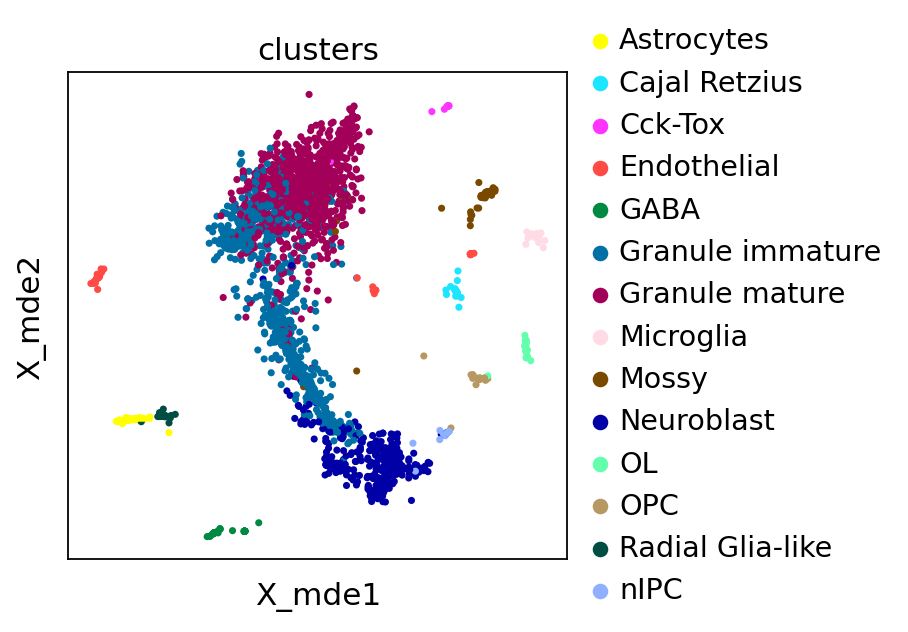

In [22]:
sc.pl.embedding(adata,
                basis='X_mde',
           color=['clusters'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

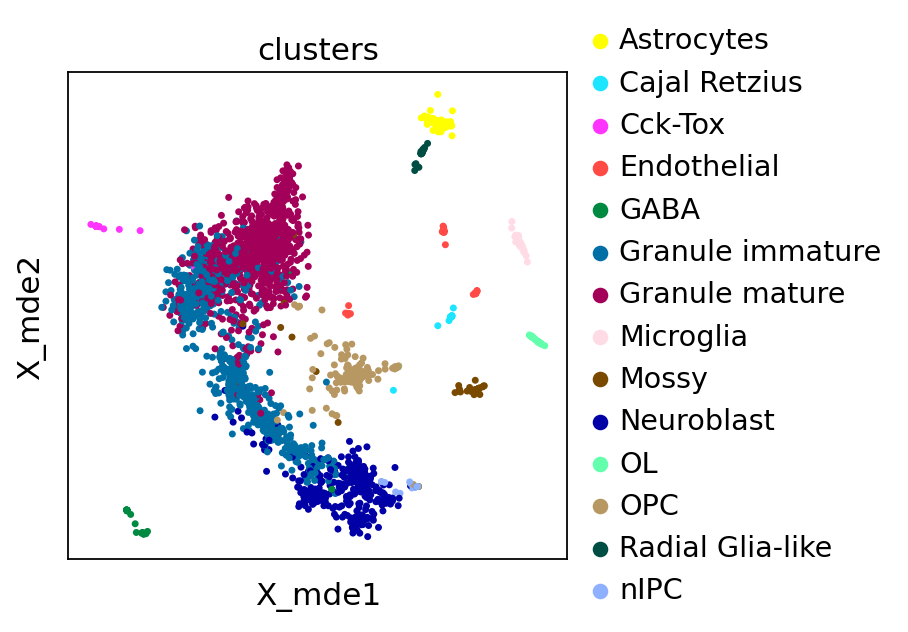

In [23]:
sc.pl.embedding(adata1,
                basis='X_mde',
           color=['clusters'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

## Visualisation of the proposed time series trajectory of cells before and after interpolation

Here, we use pyVIA to complete the calculation of the pseudotime
.

In [24]:
v0 = ov.single.pyVIA(adata=adata,adata_key='X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='clusters',knn=20,random_seed=4,root_user=['nIPC'],
                    dataset='group')
v0.run()

2023-05-27 17:30:57.081469	Running VIA over input data of 2930 (samples) x 100 (features)
2023-05-27 17:30:57.081518	Knngraph has 20 neighbors
2023-05-27 17:30:58.095812	Finished global pruning of 20-knn graph used for clustering at level of 0.15. Kept 36.5 % of edges. 
2023-05-27 17:30:58.104748	Number of connected components used for clustergraph  is 1
2023-05-27 17:30:58.163854	Commencing community detection
2023-05-27 17:30:58.191759	Finished running Leiden algorithm. Found 527 clusters.
2023-05-27 17:30:58.192455	Merging 500 very small clusters (<10)
2023-05-27 17:30:58.196490	Finished detecting communities. Found 27 communities
2023-05-27 17:30:58.196631	Making cluster graph. Global cluster graph pruning level: 0.15
2023-05-27 17:30:58.201019	Graph has 1 connected components before pruning
2023-05-27 17:30:58.202458	Graph has 10 connected components after pruning
2023-05-27 17:30:58.207689	Graph has 1 connected components after reconnecting
2023-05-27 17:30:58.208068	0.0% links t

In [25]:
v1 = ov.single.pyVIA(adata=adata1,adata_key='X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='clusters',knn=15,random_seed=4,root_user=['Neuroblast'],
                     #jac_std_global=0.01,
                    dataset='group')

v1.run()

2023-05-27 17:31:07.252008	Running VIA over input data of 3061 (samples) x 100 (features)
2023-05-27 17:31:07.252050	Knngraph has 15 neighbors
2023-05-27 17:31:08.305446	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 36.0 % of edges. 
2023-05-27 17:31:08.314440	Number of connected components used for clustergraph  is 1
2023-05-27 17:31:08.356977	Commencing community detection
2023-05-27 17:31:08.385129	Finished running Leiden algorithm. Found 516 clusters.
2023-05-27 17:31:08.385848	Merging 492 very small clusters (<10)
2023-05-27 17:31:08.389338	Finished detecting communities. Found 32 communities
2023-05-27 17:31:08.389502	Making cluster graph. Global cluster graph pruning level: 0.15
2023-05-27 17:31:08.393396	Graph has 1 connected components before pruning
2023-05-27 17:31:08.394926	Graph has 15 connected components after pruning
2023-05-27 17:31:08.402777	Graph has 1 connected components after reconnecting
2023-05-27 17:31:08.403163	0.0% links t

Text(0.5, 1.0, 'Raw Dentategyrus')

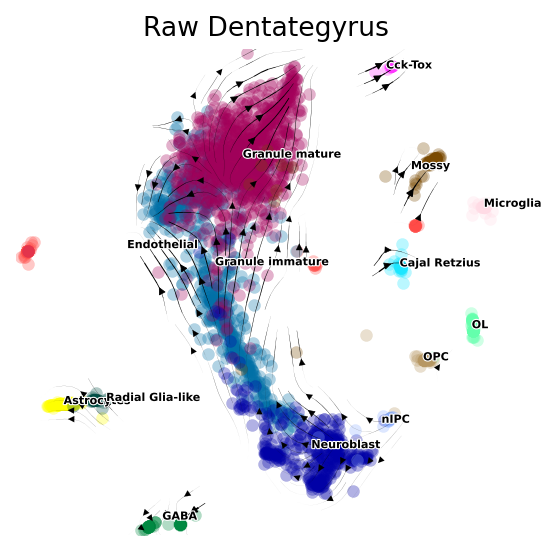

In [26]:
import matplotlib.pyplot as plt
fig,ax=v0.plot_stream(basis='X_mde',clusters='clusters',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Raw Dentategyrus',fontsize=12)
#fig.savefig('figures/v0_via_fig4.png',dpi=300,bbox_inches = 'tight')

Text(0.5, 1.0, 'Interpolation Dentategyrus')

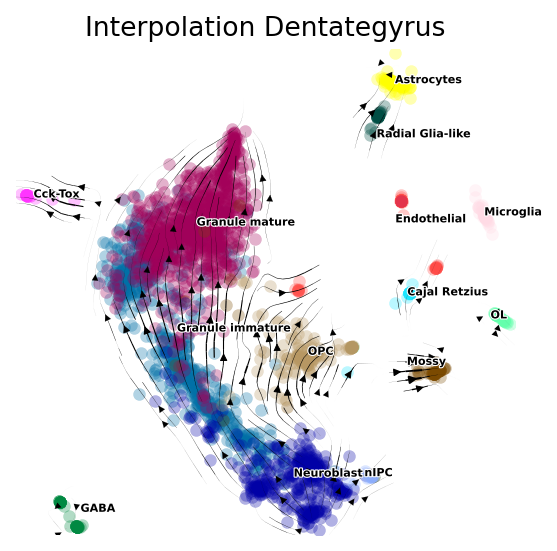

In [27]:
fig,ax=v1.plot_stream(basis='X_mde',clusters='clusters',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Interpolation Dentategyrus',fontsize=12)
#fig.savefig('figures/v1_via_fig4.png',dpi=300,bbox_inches = 'tight')

Text(0.5, 1.0, 'Raw Dentategyrus\nPseudoTime')

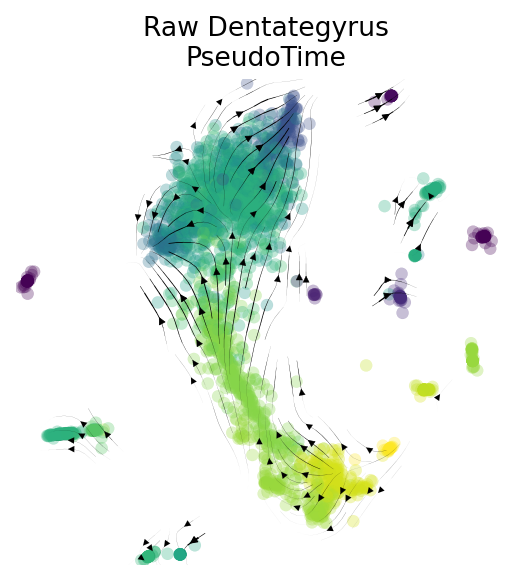

In [28]:
fig,ax=v0.plot_stream(basis='X_mde',density_grid=0.8, scatter_size=30, color_scheme='time', linewidth=0.5,
                             min_mass = 1, cutoff_perc = 5, scatter_alpha=0.3, marker_edgewidth=0.1,
                             density_stream = 2, smooth_transition=1, smooth_grid=0.5)
plt.title('Raw Dentategyrus\nPseudoTime',fontsize=12)

Text(0.5, 1.0, 'Interpolation Dentategyru\nPseudoTime')

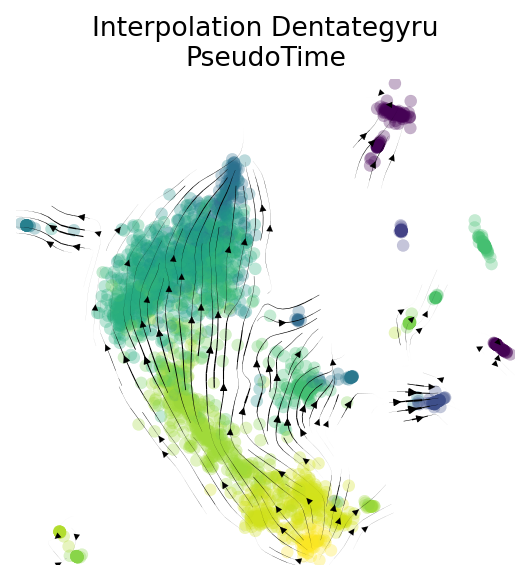

In [29]:
fig,ax=v1.plot_stream(basis='X_mde',density_grid=0.8, scatter_size=30, color_scheme='time', linewidth=0.5,
                             min_mass = 1, cutoff_perc = 5, scatter_alpha=0.3, marker_edgewidth=0.1,
                             density_stream = 2, smooth_transition=1, smooth_grid=0.5)
plt.title('Interpolation Dentategyru\nPseudoTime',fontsize=12)